In [2]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from kwave.ktransducer import kWaveGrid
from models.pact import SOS2Wavefront
from utils.dataio import *
from utils.reconstruction import get_coordinates
from utils.simulations import get_water_sos
from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

DATA_DIR = '../data/'
RESULTS_DIR = '../results_ICCV/numerical_full_apact/'

Load config file.

In [3]:
config = load_config('../config.yaml')
sample_list = [5,6,7,8,9]

### Load Images

In [4]:
v_das = 1510
v_body = 1557
n_delays = 16
lam_tv = 1e-4
hls, hfs = 0, 256
lr_nf = 5e-3

In [5]:
IP_gt = load_mat(os.path.join(DATA_DIR, 'IP_APACT_1.mat'))
IP_das = load_mat(os.path.join(RESULTS_DIR, 'DAS', f'v_das={v_das:.1f}m·s⁻¹', 'IP_rec.mat'))
IP_dual_das = load_mat(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', f'v_body={v_body:.1f}m·s⁻¹', 'IP_rec.mat'))
IP_deconv = load_mat(os.path.join(RESULTS_DIR, 'Deconv', f'{n_delays}delays_bs=64', 'IP_rec.mat'))
IP_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', f'{n_delays}delays', 'IP_rec.mat'))
IP_pg = load_mat(os.path.join(RESULTS_DIR, 'PG', f'{n_delays}delays_TV={lam_tv:.1e}_30epochs_bs=64_lr=1.0e-01', 'IP_rec.mat'))
IP_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', f'{n_delays}delays_{hls}lyrs_{hfs}fts_10epochs_bs=64_lr={lr_nf:.1e}', 'IP_rec.mat'))

SOS_gt = load_mat(os.path.join(DATA_DIR, 'SOS_apact.mat'))
SOS_uniform = load_mat(os.path.join(DATA_DIR, 'SOS_uniform.mat'))
SOS_dual = load_mat(os.path.join(DATA_DIR, 'SOS_SB.mat'))
SOS_apact = load_mat(os.path.join(RESULTS_DIR, 'APACT', f'{n_delays}delays', 'SOS_rec.mat'))
SOS_pg = load_mat(os.path.join(RESULTS_DIR, 'PG', f'{n_delays}delays_TV={lam_tv:.1e}_30epochs_bs=64_lr=1.0e-01', 'SOS_rec.mat'))
SOS_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', f'{n_delays}delays_{hls}lyrs_{hfs}fts_10epochs_bs=64_lr={lr_nf:.1e}', 'SOS_rec.mat'))

t_das = load_log(os.path.join(RESULTS_DIR, 'DAS', f'v_das={v_das:.1f}m·s⁻¹', 'log.json'))['time']
t_dual_das = load_log(os.path.join(RESULTS_DIR, 'Dual-SOS_DAS', f'v_body={v_body:.1f}m·s⁻¹', 'log.json'))['time']
t_deconv = load_log(os.path.join(RESULTS_DIR, 'Deconv', f'{n_delays}delays_bs=64', 'log.json'))['time']
t_apact = load_log(os.path.join(RESULTS_DIR, 'APACT', f'{n_delays}delays', 'log.json'))['time']
t_pg = load_log(os.path.join(RESULTS_DIR, 'PG', f'{n_delays}delays_TV={lam_tv:.1e}_30epochs_bs=64_lr=1.0e-01', 'log.json'))['time']
t_nf_apact = load_log(os.path.join(RESULTS_DIR, 'NF-APACT', f'{n_delays}delays_{hls}lyrs_{hfs}fts_10epochs_bs=64_lr={lr_nf:.1e}', 'log.json'))['time']

In [6]:
[IP_gt, IP_das, IP_dual_das, IP_deconv, IP_apact, IP_pg, IP_nf_apact] = \
    [standardize(img) for img in [IP_gt, IP_das, IP_dual_das, IP_deconv, IP_apact, IP_pg, IP_nf_apact]]
data_range_img = 15.5 # IP_das.max() - IP_das.min()
data_range_SOS = 150 # SOS_gt.max() - SOS_gt.min()
print(data_range_img, data_range_SOS)

15.5 150


In [7]:
# IP_gt.max(), IP_gt.min(), IP_das.max(), IP_das.min(), IP_dual_das.max(), IP_dual_das.min(), IP_apact.max(), IP_apact.min(), IP_nf_apact.max(), IP_nf_apact.min()

### Calculate Wavefronts

In [8]:
config = load_config(os.path.join('../', 'config.yaml'))
bps, tps = config['basic_params'], config['numerical 0']
R_ring = bps['R_ring'] # Radius to ring [m].
R_body = tps['R_body'] # Radius to center [m].
l_patch = bps['l_patch'] # Patch size [m].
kgrid = kWaveGrid([tps['Nx'], tps['Ny']], [bps['dx'], bps['dy']])
v0 = get_water_sos(tps['T'])

In [9]:
sos2wf = SOS2Wavefront(R_body, v0, kgrid.x_vec, kgrid.y_vec, n_thetas=360)
sos2wf.cuda()
sos2wf.eval()

SOS2Wavefront()

Pick a patch.

In [10]:
i, j = 18, 13 # 18, 15
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, l_patch)
x, y = (j-12)*l_patch / 4, (12-i)*l_patch / 4
k2D, theta2D = get_fourier_coord(N=80, l=l_patch, device='cpu')
print(r*1e3, phi)

4.866210024238575 2.976443976175166


Calculate ground truth and NF-APACT wavefronts.

In [11]:
thetas, wf_gt = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_gt).cuda())
wf_gt = wf_gt.squeeze(0).detach().cpu().numpy()
thetas, wf_dual = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_dual).cuda())
wf_dual = wf_dual.squeeze(0).detach().cpu().numpy()
thetas, wf_pg = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_pg).cuda())
wf_pg = wf_pg.squeeze(0).detach().cpu().numpy()
thetas, wf_nf_apact = sos2wf(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_nf_apact).cuda())
wf_nf_apact = wf_nf_apact.squeeze(0).detach().cpu().numpy()
thetas = thetas.squeeze(0).squeeze(0).detach().cpu().numpy()
wf_das = np.ones_like(wf_gt) * R_ring * (1-v0/v_das)

Calculate APACT wavefront.

In [12]:
wf_params = torch.load(os.path.join(RESULTS_DIR, 'APACT', f'{n_delays}delays', 'wf_params.pth')).detach().cpu().numpy()
dc ,x2, y2 = wf_params[i*25+j]
wf_apact = dc + x2*np.cos(2*thetas) + y2*np.sin(2*thetas)

### Numerical experiment figure 

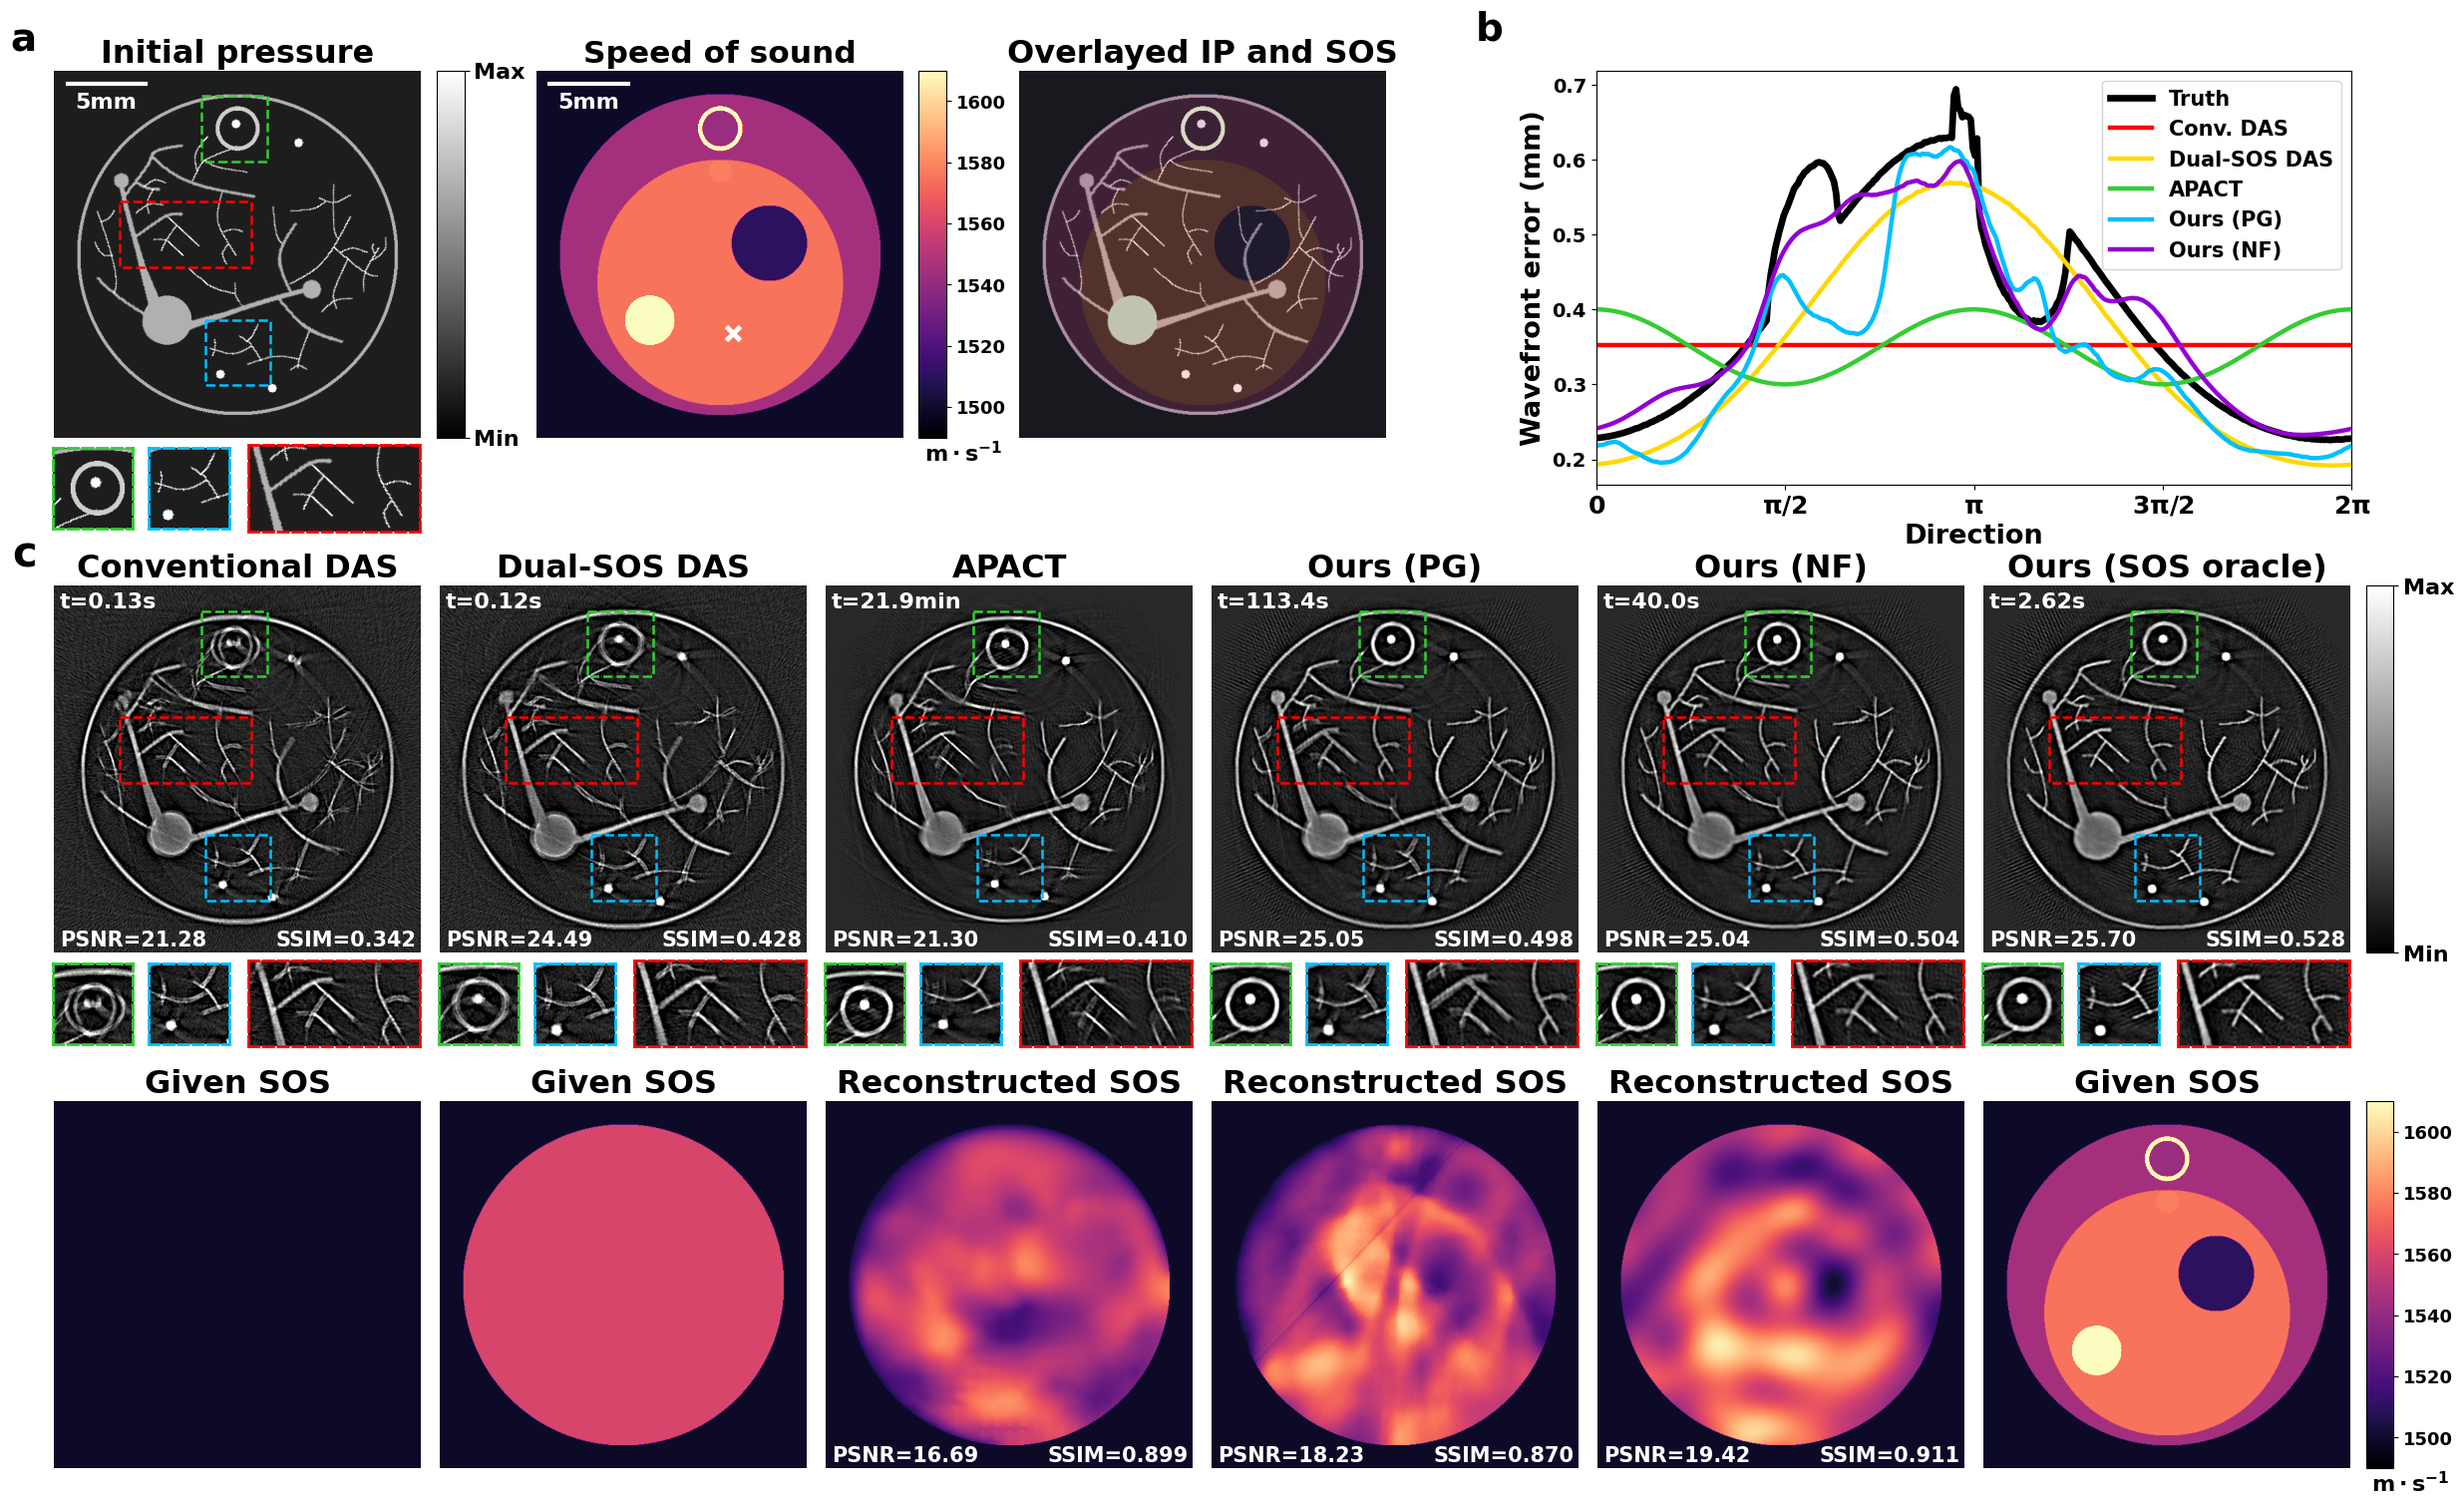

In [13]:
patches = [(38, 225, 100, 100, 'limegreen'), (380, 230, 100, 100, 'deepskyblue'), (200, 100, 100, 200, 'red')]

fig = plt.figure(figsize=(31, 18.2))
gs = GridSpec(30, 25)
norm = Normalize(vmax=5, vmin=-1)
norm_SOS = Normalize(vmax=1610, vmin=1490)

# Panel a: Numerical phantom.
ax = plt.subplot(gs[0:8,0:4])
plt.imshow(IP_gt, cmap='gray', norm=norm)
plt.title('a', loc='left', x=-0.12, y=1.03, fontsize=28, fontweight='semibold', color='black')
plt.title('Initial pressure', fontsize=23, fontweight='semibold')
plt.axis('off')
plt.plot([20, 140], [20, 20], linewidth=3, color='w')
ax.text(s='5mm', x=32, y=58, fontsize=16, fontweight='semibold', color='w')
cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.set_ticks([5, -1])
cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[8:10,k:k+1+(k==2)])
        plt.imshow(IP_gt[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

ax = plt.subplot(gs[0:8,5:9])
plt.axis('off')
plt.title('Speed of sound', fontsize=22.5, fontweight='semibold')
plt.imshow(SOS_gt, cmap='magma', norm=norm_SOS)
plt.plot(idy, idx, marker='x', mew=3.5, color='white', markersize=10)
plt.plot([20, 140], [20, 20], linewidth=3, color='w')
ax.text(s='5mm', x=32, y=58, fontsize=16, fontweight='semibold', color='w')
cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm_SOS)
cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
# cb.set_label('$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold')
cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=2, x=1.6)

ax = plt.subplot(gs[0:8,10:14])
plt.imshow(IP_gt, cmap='gray', norm=norm)
plt.imshow(SOS_gt, cmap='magma', norm=norm_SOS, alpha=0.25)
plt.title('Overlayed IP and SOS', fontsize=23, fontweight='semibold')
plt.axis('off')


# Panel b: comaping Wavefronts.
ax = plt.subplot(gs[0:9,16:24])
plt.plot(thetas, wf_gt*1e3, label='Truth', color='black', linewidth=4.8)
plt.plot(thetas, wf_das*1e3, label='Conv. DAS', color='red', linewidth=3.2)
plt.plot(thetas, wf_dual*1e3, label='Dual-SOS DAS', color='gold', linewidth=3.2)
plt.plot(thetas, wf_apact*1e3, label='APACT', color='limegreen', linewidth=3.2)
plt.plot(thetas, wf_pg*1e3, label='Ours (PG)', color='deepskyblue', linewidth=3.2)
plt.plot(thetas, wf_nf_apact*1e3, label='Ours (NF)', color='darkviolet', linewidth=3.2)
plt.legend(prop=dict(weight='bold', size=15))
plt.xlim([0, 2*np.pi])
# plt.ylim([0.09, 0.72])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], 
           ['$\mathbf{0}$', '$\mathbf{\pi/2}$', '$\mathbf{\pi}$', '$\mathbf{3\pi/2}$', '$\mathbf{2\pi}$'], fontsize=18)
plt.yticks(fontsize=14, fontweight='bold')
plt.xlabel('Direction', fontsize=19.5, fontweight='bold')
plt.ylabel('Wavefront error (mm)', fontsize=19.5, fontweight='bold')
ax.text(s='b', x=-1, y=0.76, fontsize=28, fontweight='semibold', color='black')

# Panel c: Reconstruction results.
for idx, (img, method, time, SOS, SOS_title) in enumerate(zip([IP_das, IP_dual_das,  IP_apact, IP_pg, IP_nf_apact, IP_deconv],
                                                              ['Conventional DAS', 'Dual-SOS DAS', 'APACT', 'Ours (PG)', 'Ours (NF)', 'Ours (SOS oracle)'],
                                                              ['t={:.2f}s'.format(t_das), 't={:.2f}s'.format(t_dual_das), 't={:.1f}min'.format(t_apact/60), 't={:.1f}s'.format(t_pg), 't={:.1f}s'.format(t_nf_apact), 't={:.2f}s'.format(t_deconv)],
                                                              [SOS_uniform, SOS_dual, SOS_apact, SOS_pg, SOS_nf_apact, SOS_gt],
                                                              ['Given SOS', 'Given SOS', 'Reconstructed SOS', 'Reconstructed SOS', 'Reconstructed SOS', 'Given SOS'])):
    ax = plt.subplot(gs[11:19,idx*4:(idx+1)*4])
    plt.title(method, fontsize=23, fontweight='semibold')
    plt.axis('off')
    plt.imshow(img, cmap='gray', norm=norm)
    ax.text(s=time, x=8, y=34, fontweight='semibold', fontsize=16, color='white')
    ax.text(s='PSNR={:.2f}'.format(psnr(IP_gt, img, data_range=data_range_img)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(IP_gt, img, data_range=data_range_img)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if idx == 0:
        ax.text(s='c', x=-65, y=-30, fontsize=30, fontweight='semibold', color='black')
    elif idx == 5:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
    
    for k, (x, y, h, w, color) in enumerate(patches):
        rect = plt.Rectangle((y, x), w, h, fill=False, edgecolor=color, linewidth=1.8, linestyle='--')
        ax.add_patch(rect)
        ax2 = plt.subplot(gs[19:21,idx*4+k:idx*4+k+1+(k==2)])
        plt.imshow(img[x:x+h, y:y+w], cmap='gray', norm=norm)
        plt.xticks([])
        plt.yticks([])
        for loc in ['bottom', 'top', 'left', 'right']:
            ax2.spines[loc].set_color(color)
            ax2.spines[loc].set_linewidth(2)
            ax2.spines[loc].set_linestyle('--')

    ax = plt.subplot(gs[22:30,idx*4:(idx+1)*4])
    plt.axis('off')
    plt.title(SOS_title, fontsize=23, fontweight='semibold')
    plt.imshow(SOS, cmap='magma', norm=norm_SOS)
    if idx >= 2 and idx < 5:
        ax.text(s='PSNR={:.2f}'.format(psnr(SOS, SOS_gt, data_range=data_range_SOS)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
        ax.text(s='SSIM={:.3f}'.format(ssim(SOS, SOS_gt, data_range=data_range_SOS)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if idx == 5:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        # cb.set_label('$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold')
        cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=2, x=1.6)
    
plt.savefig('figure_numerical.png', bbox_inches='tight', dpi=128)

### Supplementray figure with all numerical phantoms

In [14]:
RESULTS_DIR = '../results_ICCV/'

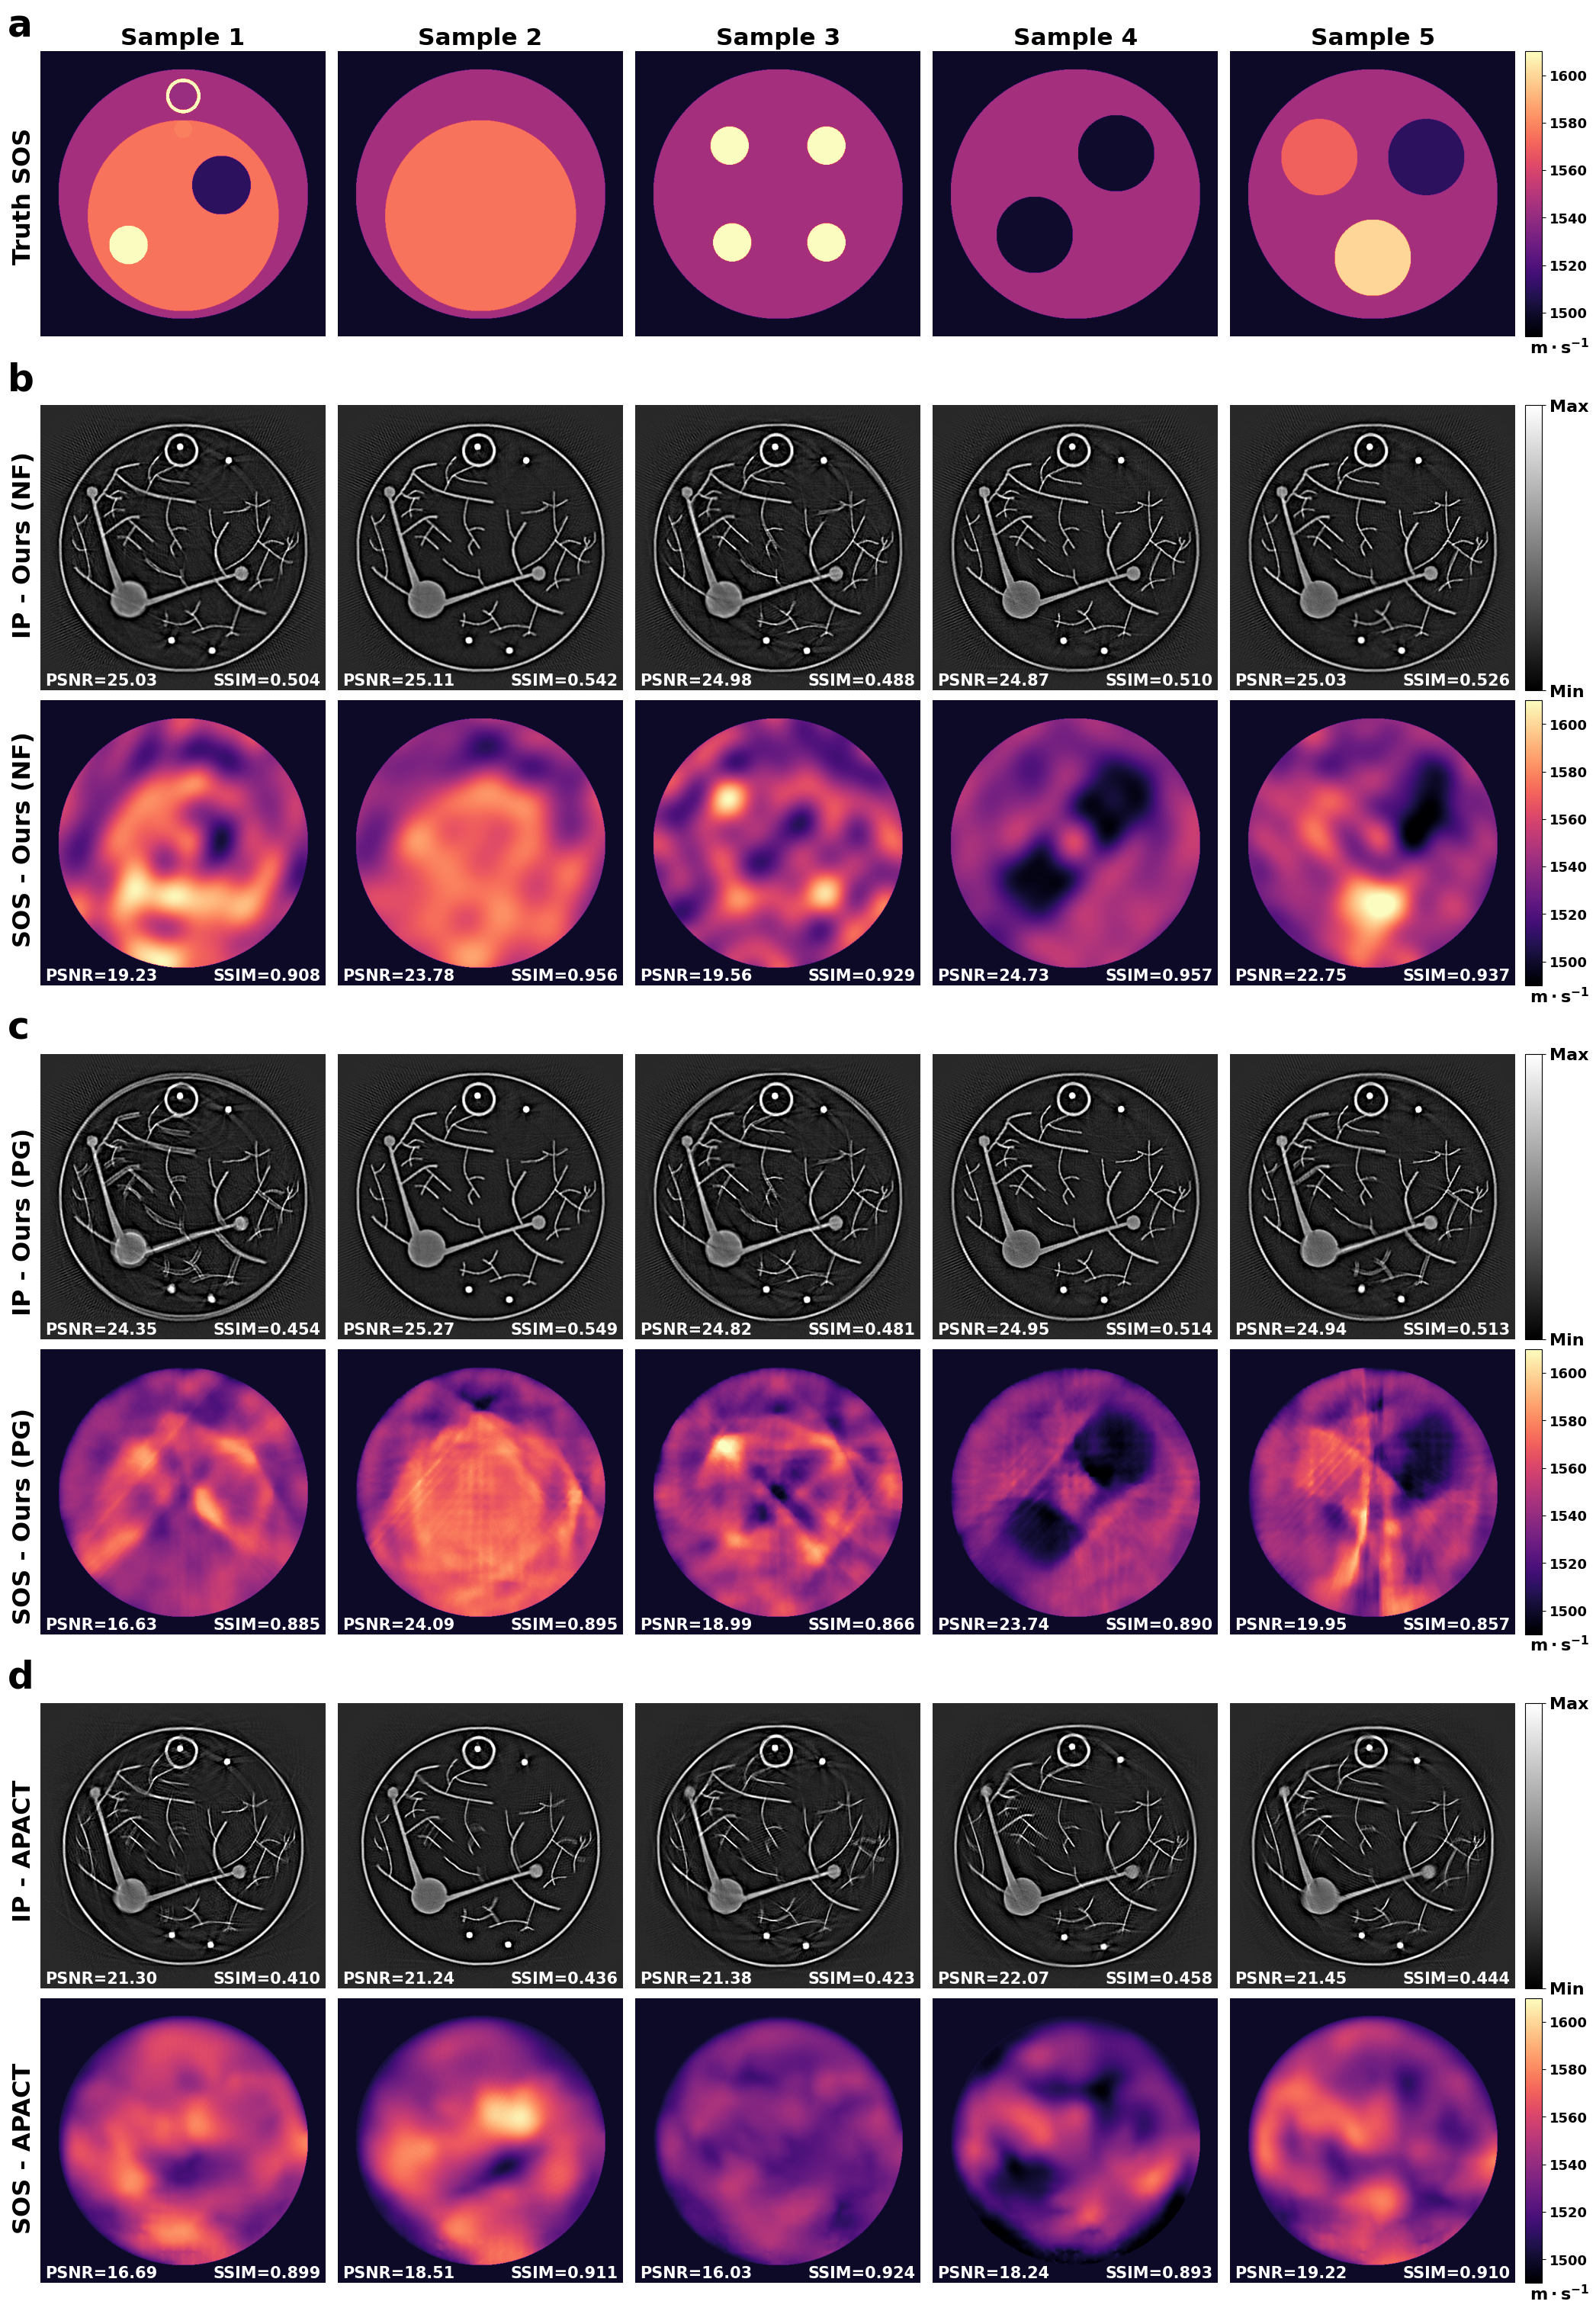

In [15]:
fig = plt.figure(figsize=(25, 38))
gs = GridSpec(38, 25)

for i, sample_id in enumerate(sample_list):
    tps = config[f'numerical {sample_id}']
    sos_gt = load_mat(os.path.join(DATA_DIR, tps['SOS']))
    
    ax = plt.subplot(gs[0:5, i*5:(i+1)*5])
    plt.axis('off')
    plt.title(f'Sample {i+1}', fontsize=22.5, fontweight='semibold')
    plt.imshow(sos_gt, cmap='magma', norm=norm_SOS)
    if i == 0:
        ax.set_title('Truth SOS', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.25)
        ax.text(s='a', x=-65, y=-30, fontsize=35, fontweight='semibold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=1, x=2)
    
    
    # Ours (NF).
    params = f'{n_delays}delays_{0}lyrs_{128}fts_{10}epochs_bs={64}_lr={lr_nf:.1e}'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'NF-APACT', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    
    ax = plt.subplot(gs[6:11, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(ip_rec, cmap='gray', norm=norm)
    ax.text(s='PSNR={:.2f}'.format(psnr(IP_gt, ip_rec, data_range=data_range_img)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(IP_gt, ip_rec, data_range=data_range_img)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('IP - Ours (NF)', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.18)
        ax.text(s='b', x=-65, y=-30, fontsize=35, fontweight='semibold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
        
    ax = plt.subplot(gs[11:16, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(sos_rec, cmap='magma', norm=norm_SOS)
    ax.text(s='PSNR={:.2f}'.format(psnr(sos_rec, sos_gt, data_range=data_range_SOS)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(sos_rec, sos_gt, data_range=data_range_SOS)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('SOS - Ours (NF)', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.13)
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=1, x=2)
    
    
    # Ours (PG).
    params = f'{n_delays}delays_TV={lam_tv:.1e}_10epochs_bs=64_lr=1.0e-01'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'PG', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    
    ax = plt.subplot(gs[17:22, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(ip_rec, cmap='gray', norm=norm)
    ax.text(s='PSNR={:.2f}'.format(psnr(IP_gt, ip_rec, data_range=data_range_img)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(IP_gt, ip_rec, data_range=data_range_img)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('IP - Ours (PG)', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.08)
        ax.text(s='c', x=-65, y=-30, fontsize=35, fontweight='semibold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
        
    ax = plt.subplot(gs[22:27, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(sos_rec, cmap='magma', norm=norm_SOS)
    ax.text(s='PSNR={:.2f}'.format(psnr(sos_rec, sos_gt, data_range=data_range_SOS)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(sos_rec, sos_gt, data_range=data_range_SOS)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('SOS - Ours (PG)', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.03)
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=1, x=2)
        
    
    # APACT.
    params = f'{n_delays}delays'
    results_path = os.path.join(RESULTS_DIR, tps['task'], 'APACT', params)
    ip_rec = load_mat(os.path.join(results_path, 'IP_rec.mat'))
    sos_rec = load_mat(os.path.join(results_path, 'SOS_rec.mat'))
    ip_rec = standardize(ip_rec)
    
    ax = plt.subplot(gs[28:33, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(ip_rec, cmap='gray', norm=norm)
    ax.text(s='PSNR={:.2f}'.format(psnr(IP_gt, ip_rec, data_range=data_range_img)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(IP_gt, ip_rec, data_range=data_range_img)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('IP - APACT', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.23)
        ax.text(s='d', x=-65, y=-30, fontsize=35, fontweight='semibold', color='black')
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm)
        cb.set_ticks([5, -1])
        cb.set_ticklabels(['Max', 'Min'], fontsize=16, fontweight='bold')
        
    ax = plt.subplot(gs[33:38, i*5:(i+1)*5])
    plt.axis('off')
    plt.imshow(sos_rec, cmap='magma', norm=norm_SOS)
    ax.text(s='PSNR={:.2f}'.format(psnr(sos_rec, sos_gt, data_range=data_range_SOS)), x=8, y=550, fontsize=15, fontweight='semibold', color='white')
    ax.text(s='SSIM={:.3f}'.format(ssim(sos_rec, sos_gt, data_range=data_range_SOS)), x=338, y=550, fontsize=15, fontweight='semibold', color='white')
    if i == 0:
        ax.set_title('SOS - APACT', fontsize=23, fontweight='bold', loc='left', rotation=90, x=-0.1, y=0.17)
    elif i == 4:
        cax = fig.add_axes([ax.get_position().x1+5e-3, ax.get_position().y0, 9e-3, ax.get_position().height])
        cb = plt.colorbar(cax=cax, norm=norm_SOS)
        cb.set_ticks([1500, 1520, 1540, 1560, 1580, 1600])
        cb.set_ticklabels(['1500', '1520', '1540', '1560', '1580', '1600'], fontsize=13, fontweight='bold')
        cb.ax.set_xlabel(r'$\mathbf{m \cdot s^{-1}}$', fontsize=16, fontweight='bold', labelpad=1, x=2)
        
plt.savefig('figure_numerical_supp.png', bbox_inches='tight', dpi=128)